In [1]:
%load_ext autoreload
%autoreload 2

# Computational model figure
## Note : 
NPG palettes available at https://nanx.me/ggsci/reference/pal_npg.html

# Todo : fix arrow tips, fix right side (cos 0 ?) recurrent arrows, rewrite 3d plot

### Imports

In [2]:
from tqdm import tqdm
import itertools

from brian2 import *
import numpy as np
from lmfit import Model, Parameters

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
from mpl_toolkits.mplot3d import axes3d
import matplotlib.patheffects as PathEffects

import MotionClouds as mc

import sys
sys.path.append('..')

#from utils import data as ut_data
#from utils import plotting as ut_plot
#from utils import inputs as ut_inp

### Params

In [3]:
N_X, N_Y = 128, 128 # MotionClouds texture size (px)

n_e = 360 # number of excitatory nodes in a ring
n_i = n_e // 4 # number of inhibitory nodes in a ring

e_radius = 1 # radius of the excitatory ring
i_radius = .8 # radius of the inhibitory ring

e_color = r'#E64B35'  # excitatory color
i_color = r'#3C5488'  # inhibitory color

s_mult = 8 # size gain, relative to node coordinate
ring_spacing = 2. # spacing between the two rings

In [4]:
rad = lambda n, rad : np.array([rad * np.cos(np.arange(0,n) * 2 * np.pi / n),
                                rad * np.sin(np.arange(0,n) * 2 * np.pi / n)])
e_xs, e_ys = rad(n_e, e_radius)
i_xs, i_ys = rad(n_i, i_radius)

### MotionClouds texture generation

In [5]:
def generate_cloud(theta, b_theta, sf_0,
                   N_X, N_Y,
                   seed, contrast=1):
    fx, fy, ft = mc.get_grids(N_X, N_Y, 1)

    mc_i = mc.envelope_gabor(fx, fy, ft,
                             V_X=0., V_Y=0., B_V=0.,
                             sf_0=sf_0, B_sf=sf_0,
                             theta=theta, B_theta=b_theta)

    im_ = mc.rectif(mc.random_cloud(mc_i, seed=seed),
                    contrast=contrast)
    return im_[:, :, 0]

### Figure

n_pop_e = n_e
n_pop_i = n_i

e_xs = e_radius * np.cos(np.arange(0,n_pop_e) * 2 * np.pi / n_pop_e )
e_ys = e_radius * np.sin(np.arange(0,n_pop_e) * 2 * np.pi / n_pop_e )
i_xs = i_radius * np.cos(np.arange(0,n_pop_i) * 2 * np.pi / n_pop_i )
i_ys = i_radius * np.sin(np.arange(0,n_pop_i) * 2 * np.pi / n_pop_i )

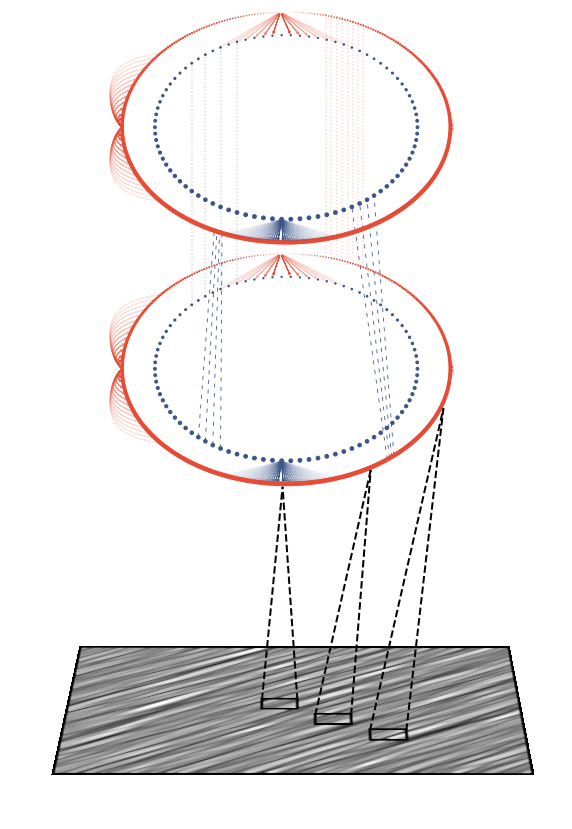

In [29]:
fig = plt.figure(figsize=(10, 15))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])


# Neural network ax
ax = plt.subplot(gs[0])

# Scattering nodes, first layer
ax.scatter(e_xs, e_ys, c=e_color,
           s=s_mult*(-e_ys + np.abs(np.min(e_ys))),
           zorder=500)
ax.scatter(i_xs, i_ys, c=i_color,
           s=s_mult*(-i_ys + np.abs(np.min(e_ys))),
           zorder=500)

# Nodes, second layer
ax.scatter(e_xs, e_ys+2.1, c=e_color,
           s=s_mult * (-e_ys+np.abs(np.min(e_ys)+ring_spacing)))
ax.scatter(i_xs, i_ys+2.1, c=i_color,
           s=s_mult * (-i_ys+np.abs(np.min(e_ys)+ring_spacing)))


def recurrent_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3, color=e_color,
                      xs=e_xs, ys=e_ys, yfrom_rectif = 0., yto_rectif=-.03):
    style = "Simple,tail_width=0.2,head_width=2,head_length=2"
    kw = dict(arrowstyle=style, edgecolor=color)
    alphas = 1 / np.exp(np.linspace(0., 2.5*e, n_arrows))
    lspace = np.linspace(i0_arrows, n_arrows, n_arrows // step_arrows, dtype=int)
    
    for i0, x in enumerate(lspace):
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif) ,
                                      (xs[idx+x], ys[idx+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' %  .75,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)
    
    for i0, x in enumerate(-lspace) :
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif ),
                                      (xs[idx+x], ys[idx+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % -.75 ,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)

# Connect L1 exc-exc nodes
recurrent_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3, color=e_color,
                  xs=e_xs, ys=e_ys, yfrom_rectif = 0., yto_rectif=0.)

# Connect L2 exc-exc nodes
recurrent_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3,color=e_color,
                  xs=e_xs, ys=e_ys, yfrom_rectif = 2.1, yto_rectif=2.1)

# Connect L1 inh-inh nodes
recurrent_connect(idx=0, n_arrows=10, i0_arrows=1, step_arrows=1, color=e_color,
                  xs=e_xs, ys=e_ys, yfrom_rectif = 0., yto_rectif=0.)

# Connect L2 inh-inh nodes
recurrent_connect(idx=0, n_arrows=10, i0_arrows=1, step_arrows=1, color=e_color,
                  xs=e_xs, ys=e_ys, yfrom_rectif = 2.1, yto_rectif=2.1)




def layer_connect(idx=180, n_arrows=40, i0_arrows=5, step_arrows=3, color=e_color,
                    xs=e_xs, ys=e_ys, xs2=i_xs, ys2=i_ys, mult_connect = 4,
                    yfrom_rectif = 0., yto_rectif=-.03):
    style = "Simple,tail_width=0.2,head_width=2,head_length=2"
    kw = dict(arrowstyle=style, edgecolor=color)
    alphas = 1 / np.exp(np.linspace(0., e, n_arrows))
    lspace = np.linspace(i0_arrows, n_arrows, n_arrows // step_arrows, dtype=int)
    
    for i0, x in enumerate(lspace):
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif) ,
                                      (xs2[int(idx*mult_connect)+x], ys2[int(idx*mult_connect)+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % .01,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)
    
    for i0, x in enumerate(-lspace) :
        arr = patches.FancyArrowPatch((xs[idx], ys[idx]+ yfrom_rectif ),
                                      (xs2[int(idx*mult_connect)+x], ys2[int(idx*mult_connect)+x] + yto_rectif),
                                      facecolor='none',
                                      connectionstyle='arc3, rad = %.2f' % -.01,
                                      alpha=alphas[i0],
                                      **kw)
        ax.add_patch(arr)

# Connect L1 exc-inh nodes        
layer_connect(idx=92, n_arrows=8, i0_arrows=1, step_arrows=1, color=e_color,
                xs=e_xs, ys=e_ys, xs2 = i_xs, ys2 = i_ys, mult_connect = .25,
                yfrom_rectif = 0., yto_rectif= 0.)

# Connect L2 exc-inh nodes
layer_connect(idx=92, n_arrows=8, i0_arrows=1, step_arrows=1, color=e_color,
                xs=e_xs, ys=e_ys, xs2 = i_xs, ys2 = i_ys, mult_connect = .25,
                yfrom_rectif = 2.1, yto_rectif= 2.1)

# Connect L1 inh-exc nodes
layer_connect(idx=67, n_arrows=20, i0_arrows=1, step_arrows=1, color=i_color,
                xs=i_xs, ys=i_ys, xs2 = e_xs, ys2 = e_ys, mult_connect = 4,
                yfrom_rectif = 0., yto_rectif= 0.)

# Connect L2 inh-exc nodes
layer_connect(idx=67, n_arrows=20, i0_arrows=1, step_arrows=1, color=i_color,
                xs=i_xs, ys=i_ys, xs2 = e_xs, ys2 = e_ys, mult_connect = 4,
                yfrom_rectif = 2.1, yto_rectif= 2.1)




def forward_connect(idx=180, n_arrows=40, step_arrows=3, color=e_color, lw = .3,
                    xs=e_xs, ys=e_ys, xs2=i_xs, ys2=i_ys, mult_connect = 4,
                    add_idx = 10,  yto_rectif=-.03):
    lspace = np.arange(-n_arrows, n_arrows, step_arrows, dtype=int)
    
    for i0, x in enumerate(lspace):
        ax.plot((xs[idx+x], xs2[int(mult_connect*idx)+x+add_idx]),
                (ys[idx+x], ys2[int(mult_connect*idx)+x+add_idx]+yto_rectif),
                color=color, linestyle=(0, (5, 7)),
                linewidth=lw, zorder=-1)
        ax.arrow(xs[idx+x], ys[idx+x]+yto_rectif, 0, .005,
                    color=color, linewidth=.1 * (-ys[idx+x]+np.abs(np.min(ys))),
                    head_width=.0075, zorder=-1)


# Connect L1 to L2 exc nodes
forward_connect(idx=70, n_arrows=8, step_arrows=2, color=e_color, lw = .3,
                xs=e_xs, ys=e_ys, xs2 = e_xs, ys2 = e_ys, mult_connect = 1,
                add_idx = 0, yto_rectif= 2.1)

# Connect L1 to L2 inh nodes
forward_connect(idx=32, n_arrows=4, step_arrows=2, color=i_color, lw = .3,
                xs=i_xs, ys=i_ys, xs2 = i_xs, ys2 = i_ys, mult_connect = 1,
                add_idx = 0, yto_rectif= 2.1)

# Connect L1 inh to L2 exc nodes
forward_connect(idx=59, n_arrows=2, step_arrows=1, color=i_color, lw = .8,
                xs=i_xs, ys=i_ys, xs2 = e_xs, ys2 = e_ys, mult_connect = 4,
                add_idx = 10, yto_rectif= 2.1)

# Connect L1 exc to L2 inh nodes
forward_connect(idx=310, n_arrows=2, step_arrows=1, color=i_color, lw = .8,
                xs=e_xs, ys=e_ys, xs2 = i_xs, ys2 = i_ys, mult_connect = .25,
                add_idx = 0, yto_rectif= 2.1)

ax.set_xlim(-1.7, 1.7)
ax.set_ylim(-1.05, 3.15)


ax2 = plt.subplot(gs[1], projection='3d')

xx, yy = np.meshgrid(np.arange(0, 256), np.arange(0, 256))
im = generate_cloud(np.pi/4, np.pi/36, .1, 256, 256, 42)

s = 20

x0 = 109
wx = 2
wy = 5
im[x0:x0+s, x0:x0+wy] = 0
im[x0:x0+wx, x0:x0+s] = 0
im[x0:x0+s, x0+s:x0+s+wy] = 0
im[x0+s:x0+s+wx, x0:x0+s+wy] = 0

ax2.plot((x0+5, 126), (x0+.5, 122), (0, .21), clip_on=False, color='k', zorder=100,
         linewidth=2, linestyle='--')
ax2.plot((x0+5, 126), (x0+20+.5, 122), (0, .21), clip_on=False, color='k', zorder=100,
         linewidth=2, linestyle='--')


x0 = 139
wx = 2
wy = 5
im[x0:x0+s, x0:x0+wy] = 0
im[x0:x0+wx, x0:x0+s] = 0
im[x0:x0+s, x0+s:x0+s+wy] = 0
im[x0+s:x0+s+wx, x0:x0+s+wy] = 0

ax2.plot((x0+5, 126), (x0+.5, 165), (0, .224), clip_on=False, color='k', zorder=100,
         linewidth=2, linestyle='--')
ax2.plot((x0+5, 126), (x0+20+.5, 165), (0, .224), clip_on=False, color='k', zorder=100,
         linewidth=2, linestyle='--')


x0 = 169
wx = 2
wy = 5
im[x0:x0+s, x0:x0+wy] = 0
im[x0:x0+wx, x0:x0+s] = 0
im[x0:x0+s, x0+s:x0+s+wy] = 0
im[x0+s:x0+s+wx, x0:x0+s+wy] = 0

ax2.plot((x0+5, 126), (x0+.5, 198), (0, .273), clip_on=False, color='k', zorder=100,
         linewidth=2, linestyle='--')
ax2.plot((x0+5, 126), (x0+20+.5, 198), (0, .273), clip_on=False, color='k', zorder=100,
         linewidth=2, linestyle='--')


s = 254
x0 = 0
wx = 2
wy = 4
im[x0:x0+s, x0:x0+wy] = 0
im[x0:x0+wx, x0:x0+s] = 0
im[x0:x0+s, x0+s-2:x0+s+wy] = 0
im[x0+s:x0+s+wx, x0:x0+s+wy] = 0


ax2.contourf(xx, yy, im, 100,  offset=0., cmap='gray', zorder=0)

ax2.set_zlim(-.08, .1)
ax2.view_init(elev=40, azim=.2)
ax2.dist = 6.

plt.subplots_adjust(hspace=.25)
ax.axis('off')
ax2.axis('off')
plt.show()


fig.savefig('fig1_rings.pdf', format='pdf', bbox_inches='tight')
fig.savefig('fig1_rings.png', format='png', bbox_inches='tight')

In [7]:
# e_e connectivity
'''idxfrom = 180
naxones = 40

style = "Simple,tail_width=0.2,head_width=2,head_length=2"
kw = dict(arrowstyle=style, edgecolor=e_color)
alphas = 1/np.exp(np.linspace(0, 2.5*e, naxones))

for i, x in enumerate(np.linspace(5, naxones, naxones//3, dtype=int)):

    a1 = patches.FancyArrowPatch((e_xs[idxfrom], e_ys[idxfrom]),
                                 (e_xs[idxfrom+x], e_ys[idxfrom+x]-.03),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=.75", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)

for i, x in enumerate(np.linspace(-5, -naxones, naxones//3, dtype=int)):
    a1 = patches.FancyArrowPatch((e_xs[idxfrom], e_ys[idxfrom]),
                                 (e_xs[idxfrom+x], e_ys[idxfrom+x]+.02),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=-.75", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)'''

'idxfrom = 180\nnaxones = 40\n\nstyle = "Simple,tail_width=0.2,head_width=2,head_length=2"\nkw = dict(arrowstyle=style, edgecolor=e_color)\nalphas = 1/np.exp(np.linspace(0, 2.5*e, naxones))\n\nfor i, x in enumerate(np.linspace(5, naxones, naxones//3, dtype=int)):\n\n    a1 = patches.FancyArrowPatch((e_xs[idxfrom], e_ys[idxfrom]),\n                                 (e_xs[idxfrom+x], e_ys[idxfrom+x]-.03),\n                                 facecolor=\'none\',\n                                 connectionstyle="arc3,rad=.75", alpha=alphas[i],\n                                 **kw)\n    ax.add_patch(a1)\n\nfor i, x in enumerate(np.linspace(-5, -naxones, naxones//3, dtype=int)):\n    a1 = patches.FancyArrowPatch((e_xs[idxfrom], e_ys[idxfrom]),\n                                 (e_xs[idxfrom+x], e_ys[idxfrom+x]+.02),\n                                 facecolor=\'none\',\n                                 connectionstyle="arc3,rad=-.75", alpha=alphas[i],\n                                 **kw)\n

In [8]:
# samel2
idxfrom = 180
naxones = 40

'''style = "Simple,tail_width=0.2,head_width=2,head_length=2"
kw = dict(arrowstyle=style, edgecolor=e_color)
alphas = 1/np.exp(np.linspace(0, 2.5*e, naxones))

for i, x in enumerate(np.linspace(5, naxones, naxones//3, dtype=int)):

    a1 = patches.FancyArrowPatch((e_xs[idxfrom], e_ys[idxfrom]+2.1),
                                 (e_xs[idxfrom+x], e_ys[idxfrom+x]-.03+2.1),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=.75", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)

for i, x in enumerate(np.linspace(-5, -naxones, naxones//3, dtype=int)):
    a1 = patches.FancyArrowPatch((e_xs[idxfrom], e_ys[idxfrom]+2.1),
                                 (e_xs[idxfrom+x], e_ys[idxfrom+x]+.02+2.1),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=-.75", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-8-6a8c57802cfd>, line 24)

In [ ]:
# i_i connectivity
idxfrom = 0
naxones = 10
kw = dict(arrowstyle=style, edgecolor=i_color)
alphas = 1/np.exp(np.linspace(0, 1.*e, naxones))

for i, x in enumerate(np.linspace(1, naxones, naxones//1, dtype=int)):

    a1 = patches.FancyArrowPatch((i_xs[idxfrom], i_ys[idxfrom]),
                                 (i_xs[idxfrom+x], i_ys[idxfrom+x]),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=.75", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)

for i, x in enumerate(np.linspace(-1, -naxones, naxones//1, dtype=int)):
    a1 = patches.FancyArrowPatch((i_xs[idxfrom], i_ys[idxfrom]),
                                 (i_xs[idxfrom+x], i_ys[idxfrom+x]),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=-.75", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)

In [ ]:
# samel2
idxfrom = 0
naxones = 10
kw = dict(arrowstyle=style, edgecolor=i_color)
alphas = 1/np.exp(np.linspace(0, 1.*e, naxones))

for i, x in enumerate(np.linspace(1, naxones, naxones//1, dtype=int)):

    a1 = patches.FancyArrowPatch((i_xs[idxfrom], i_ys[idxfrom]+2.1),
                                 (i_xs[idxfrom+x], i_ys[idxfrom+x]+2.1),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=.75", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)

for i, x in enumerate(np.linspace(-1, -naxones, naxones//1, dtype=int)):
    a1 = patches.FancyArrowPatch((i_xs[idxfrom], i_ys[idxfrom]+2.1),
                                 (i_xs[idxfrom+x], i_ys[idxfrom+x]+2.1),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=-.75", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)

In [ ]:
# e_i connectivity
idxfrom = 92
naxones = 8
kw = dict(arrowstyle=style, edgecolor=e_color)
alphas = 1/np.exp(np.linspace(0, 1.*e, naxones))

for i, x in enumerate(np.linspace(1, naxones, naxones//1, dtype=int)):

    a1 = patches.FancyArrowPatch((e_xs[idxfrom], e_ys[idxfrom]),
                                 (i_xs[(idxfrom//4)+x], i_ys[(idxfrom//4)+x]),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=.01", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)

for i, x in enumerate(np.linspace(0, -naxones, naxones//1, dtype=int)):
    a1 = patches.FancyArrowPatch((e_xs[idxfrom], e_ys[idxfrom]),
                                 (i_xs[(idxfrom//4)+x], i_ys[(idxfrom//4)+x]),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=-.01", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)


In [ ]:




# samel2
idxfrom = 92
naxones = 8
kw = dict(arrowstyle=style, edgecolor=e_color)
alphas = 1/np.exp(np.linspace(0, 1.*e, naxones))

for i, x in enumerate(np.linspace(1, naxones, naxones//1, dtype=int)):

    a1 = patches.FancyArrowPatch((e_xs[idxfrom], e_ys[idxfrom]+2.1),
                                 (i_xs[(idxfrom//4)+x],
                                  i_ys[(idxfrom//4)+x]+2.1),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=.01", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)

for i, x in enumerate(np.linspace(0, -naxones, naxones//1, dtype=int)):
    a1 = patches.FancyArrowPatch((e_xs[idxfrom], e_ys[idxfrom]+2.1),
                                 (i_xs[(idxfrom//4)+x],
                                  i_ys[(idxfrom//4)+x]+2.1),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=-.01", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)


In [ ]:
# i_e connectivity
idxfrom = 67
naxones = 20
kw = dict(arrowstyle=style, edgecolor=i_color)
alphas = 1/np.exp(np.linspace(0, 1.5*e, naxones))

for i, x in enumerate(np.linspace(1, naxones, naxones//2, dtype=int)):

    a1 = patches.FancyArrowPatch((i_xs[idxfrom]+.005, i_ys[idxfrom]-.008),
                                 (e_xs[(idxfrom*4)+x],
                                  e_ys[(idxfrom*4)+x]+.02),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=.01", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)

for i, x in enumerate(np.linspace(-1, -naxones, naxones//2, dtype=int)):
    a1 = patches.FancyArrowPatch((i_xs[idxfrom] - .005, i_ys[idxfrom]-.008),
                                 (e_xs[(idxfrom*4)+x],
                                  e_ys[(idxfrom*4)+x]+.02),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=-.01", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)


# samel2
idxfrom = 67
naxones = 20
kw = dict(arrowstyle=style, edgecolor=i_color)
alphas = 1/np.exp(np.linspace(0, 1.5*e, naxones))

for i, x in enumerate(np.linspace(1, naxones, naxones//2, dtype=int)):

    a1 = patches.FancyArrowPatch((i_xs[idxfrom]+.005, i_ys[idxfrom]-.008+2.1),
                                 (e_xs[(idxfrom*4)+x],
                                  e_ys[(idxfrom*4)+x]+.02+2.1),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=.01", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)

for i, x in enumerate(np.linspace(-1, -naxones, naxones//2, dtype=int)):
    a1 = patches.FancyArrowPatch((i_xs[idxfrom] - .005, i_ys[idxfrom]-.008+2.1),
                                 (e_xs[(idxfrom*4)+x],
                                  e_ys[(idxfrom*4)+x]+.02+2.1),
                                 facecolor='none',
                                 connectionstyle="arc3,rad=-.01", alpha=alphas[i],
                                 **kw)
    ax.add_patch(a1)



In [ ]:
idxfrom = 70
naxones = 8
alphas = 1/np.exp(np.linspace(0, 1.5*e, naxones))
xs = e_xs
ys = e_ys
idx = 70
yto_rectif = 2.1
for i, x in enumerate(np.arange(-naxones, naxones, 2, dtype=int)):
    ''' ax.plot((e_xs[idxfrom+x], e_xs[idxfrom+x]),
             (e_ys[idxfrom+x]+.01, e_ys[idxfrom+x]+2.075),
             color=e_color, linestyle=(0, (5, 7)),
             linewidth=.3,
             zorder=-1)'''
    
    

    ax.arrow(e_xs[idxfrom+x], e_ys[idxfrom+x]+2.075,
              0, .005,
              color=e_color, linewidth=.1 *
              (-e_ys[idxfrom+x]+np.abs(np.min(e_ys))),
              head_width=.0075,
              zorder=-1)

In [ ]:
# i_i layer connectivity, using arrow not arrowpatch
idxfrom = 32
naxones = 4
alphas = 1/np.exp(np.linspace(0, 1.5*e, naxones))

kw = dict(arrowstyle=style, edgecolor=i_color)
for i, x in enumerate(np.arange(-naxones, naxones, 1, dtype=int)):
    plt.plot((i_xs[idxfrom+x], i_xs[idxfrom+x]),
             (i_ys[idxfrom+x]+.01, i_ys[idxfrom+x]+2.075),
             color=i_color, linestyle=(0, (5, 7)),
             linewidth=.3,
             zorder=-1)

    plt.arrow(i_xs[idxfrom+x], i_ys[idxfrom+x]+2.075,
              0, .005,
              color=i_color, linewidth=.1 *
              (-e_ys[idxfrom+x]+np.abs(np.min(e_ys))),
              head_width=.0075,
              zorder=-1)

In [ ]:
# i_e layer connectivity, using arrow not arrowpatch
idxfrom = 59
naxones = 2
alphas = 1/np.exp(np.linspace(0, 1.5*e, naxones))

kw = dict(arrowstyle=style, edgecolor=i_color)
for i, x in enumerate(np.arange(-naxones, naxones, 1, dtype=int)):
    plt.plot((i_xs[idxfrom+x], e_xs[4*idxfrom+x+10]),
             (i_ys[idxfrom+x]+.01, e_ys[(4*idxfrom)+x+10]+2.055),
             color=i_color, linestyle=(0, ((5, 7))),
             linewidth=.8,
             zorder=-1)

    plt.arrow(e_xs[4*idxfrom+x+10], e_ys[(4*idxfrom)+x+10]+2.055,
              .00075, .005,
              color=i_color, linewidth=.1 *
              (-e_ys[idxfrom+x]+np.abs(np.min(e_ys))),
              head_width=.0075,
              zorder=-1)

In [ ]:

# e_i layer connectivity, using arrow not arrowpatch
idxfrom = 310
naxones = 2

kw = dict(arrowstyle=style, edgecolor=e_color)
for i, x in enumerate(np.arange(-naxones, naxones, 1, dtype=int)):
    plt.plot((e_xs[idxfrom+x], i_xs[idxfrom//4+x]+.002),
             (e_ys[idxfrom+x], i_ys[idxfrom//4+x]+2.061),
             color=e_color, linestyle=(0, (5, 7)),
             linewidth=.8,
             zorder=-1)

    plt.arrow(i_xs[idxfrom//4+x]+.002, i_ys[idxfrom//4+x]+2.061,
              -0.001, .005,
              color=e_color, linewidth=.1 *
              (-e_ys[idxfrom+x]+np.abs(np.min(e_ys))),
              head_width=.0075,
              zorder=-1)